### Imports

In [5]:
# data handling
import numpy    as np
import xarray   as xr

# math
import math
# from scipy.stats import norm

# plotting
import matplotlib.pyplot    as plt
import matplotlib.animation as animation
from   IPython.display      import HTML
import cmocean

# ray tracing
import mantaray
from mantaray.core import single_ray, ray_tracing

### Helper Functions

In [ ]:
g = 9.81 # Acceleration due to gravity [m/s^2]

In [9]:
def period2wavenumber(T):
    """Converts wave period (T) to wavenumber (k) for deep water waves"""
    k = (2*math.pi)**2 / (g*T**2)
    
    return k

In [10]:
def group_velocity(k):
    """Computes the group velocity from wavenumber (k) for deep water waves"""
    c_g = (g/k)**.5 / 2
    
    return c_g

In [13]:
def compute_cfl(x, y, k0):
    """Computes the optimal timestep for the model based on grid cell size and initial wave group velocity"""
    dd  = np.min([np.diff(x).mean(), np.diff(y).mean()])
    c_g = group_velocity(k0)
    
    cfl = dd / c_g
    return cfl

In [ ]:
def compute_duration(x, k0):
    """Computes the optimal model duration based on the x distance and the initial wave group velocity"""
    c_g = group_velocity(k0)

    return round(x.max() / c_g)

In [56]:
def animate_rays(X, Y, background, bando, style, ray_sample=1, time_sample=10):
    """Generates frame for animating ray solutions"""
    time_steps = bando.time_step.size

    # Initializes figure
    fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)

    # Plots initial frame
    if style=='currents':
        cf   = ax.contourf(X, Y, background, cmap=cmocean.cm.speed, levels=50)
        cbar = fig.colorbar(cf)
        cbar.set_label("Speed [m/s]")
    if style=='bathymetry':
        cf   = ax.contourf(X, Y, background, cmap=cmocean.cm.deep, levels=50)
        cbar = fig.colorbar(cf)
        cbar.set_label("Depth [m]")

    # Initializes ray plots
    ray_lines = []
    for i in range(0, bando.ray.size, ray_sample):
        if style=='currents':
            ray, = ax.plot([], [], 'k', lw=0.78, color='black')
        if style=='bathymetry':
            ray, = ax.plot([], [], 'k', lw=0.78, color='white')
        ray_lines.append(ray)

    # Set labels and limits
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.set_title("Ray Tracing Animation")

    # Define update function for animation
    def animate(frame):
        for i, ray_line in enumerate(ray_lines):
            ray = bando.isel(ray=i * ray_sample).sel(time_step=slice(0, frame))
            ray_line.set_data(ray.x, ray.y)  # Updates ray paths

        ax.set_title(f"Ray Tracing Animation - Time Step {frame}")

    # Compiles animation
    anim = animation.FuncAnimation(fig, animate, frames=range(0, time_steps, time_sample), interval=100)

    plt.close(fig)
    return anim

# Introduction

This notebook covers how to run the Mantaray model with the custom depth and current fields that were built in `idealized_fields.ipynb`.

# Initial Wave and Model Parameters

The initial wave parameters that we need to define for Mantaray are $k_{x0}$/$k_{y_0}$, the initial x/y wavenumber. To find these, we will define:
- $T_0$: The initial way period,
- $\theta_0$: The initial wave direction (convention: what direction the waves are *going to*),
- $n_{rays}$: The number of rays.

Using these parameters, we will compute our initial grid of x/y wavenumbers. All waves will have the same x/y wavenumbers. We will use these initial parameters for the 4 canonical examples.

In [17]:
T0      = 10 # Period [s]
theta0  = 0  # Direction [rad]

In [18]:
# Convert period to wavenumber magnitude
k_0 = period2wavenumber(T0)

# Calculate wavenumber components
k_x0 = k_0 * np.cos(theta0)
k_y0 = k_0 * np.sin(theta0)

In [36]:
# Number of rays
n_rays = 100

# Initialize wavenumber for all rays
K_x0 = k_x0 * np.ones(n_rays)
K_y0 = k_y0 * np.ones(n_rays)

Additionally, we need to define the initial positions for all of our rays. To do this, we will extract the grid from one of our canonical examples. All examples have the same grid, and the initial positions for all rays will be the same for each canonical example.

In [22]:
ds_jet = xr.open_dataset('./data/currents/jet.nc')

In [23]:
# Read x and y from file to get domain size
x = ds_jet.x.values
y = ds_jet.y.values

In [24]:
x0 = 0 * np.ones(n_rays)
y0 = np.linspace(0, y.max(), n_rays)

Additionally, using the grid, we can compute the optimal timestep and duration for each model.

In [25]:
timestep = compute_cfl(x, y, k_0)
duration = compute_duration(x, k_0)

# Ray Tracing with Mantaray

In [26]:
mantaray.ray_tracing?

Signature:
mantaray.ray_tracing(
    x0,
    y0,
    kx0,
    ky0,
    duration: float,
    step_size: float,
    bathymetry: str,
    current: str,
) -> xarray.core.dataset.Dataset
Docstring:
Ray tracing for multiple initial conditions

For a given set of initial conditions, progapage those multiple rays in
parallel and return the projections for each ray

Parameters
----------
x0 : Sequence[float]
    Initial x position of the ray
y0 : Sequence[float]
    Initial y position of the ray
kx0 : Sequence[float]
    Initial wavenumber, x component
ky0 : Sequence[float]
    Initial wavenumber, y component
duration : float
    Duration of the simulation
step_size : float
    Time step for the simulation
bathymetry : str
    Path to a netCDF file containing the bathymetry file. It is expected
    x and y dimensions as floats and depth (x, y) as a float, where
    depth is zero at surface and positive downwards.
current : str
    Paths to a netCDF file containing the current field. It is expec

The core ray tracing function expects to get:
- Initial x/y position(s),
- Initial $k_{x0}$/$k_{y0}$(s),
- Model duration,
- Model timestep,
- Bathymetry/Current `xarray` `datasets` *paths* as *strings*

## Zonal Jet

In [27]:
jet_path         = './data/currents/jet.nc'
const_bathy_path = './data/bathymetry/constant.nc'

In [37]:
bundle_jet = mantaray.ray_tracing(x0, y0, K_x0, K_y0, 
                                    duration, timestep, 
                                    const_bathy_path, jet_path)

We can make a quick plot to see if this is working properly before creating animations.

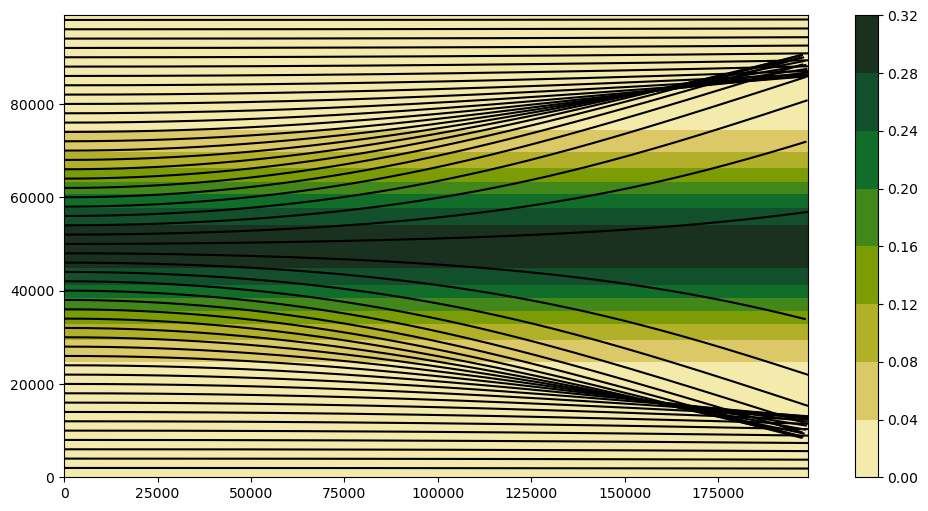

In [38]:
X = ds_jet.x
Y = ds_jet.y
U = (ds_jet.u**2 + ds_jet.v**2)**.5

plt.figure(figsize=(12, 6))

cf = plt.contourf(X, Y, U, cmap=cmocean.cm.speed)

for i in range(bundle_jet.ray.size)[::2]:
    ray = bundle_jet.isel(ray=i)
    plt.plot(ray.x.values, ray.y.values, color='black')

plt.colorbar(cf)

## Mesoscale Eddy

In [42]:
eddy_path = './data/currents/eddy.nc'

In [43]:
bundle_eddy = mantaray.ray_tracing(x0, y0, K_x0, K_y0, 
                                    duration, timestep, 
                                    const_bathy_path, eddy_path)

In [44]:
ds_eddy = xr.open_dataset(eddy_path)

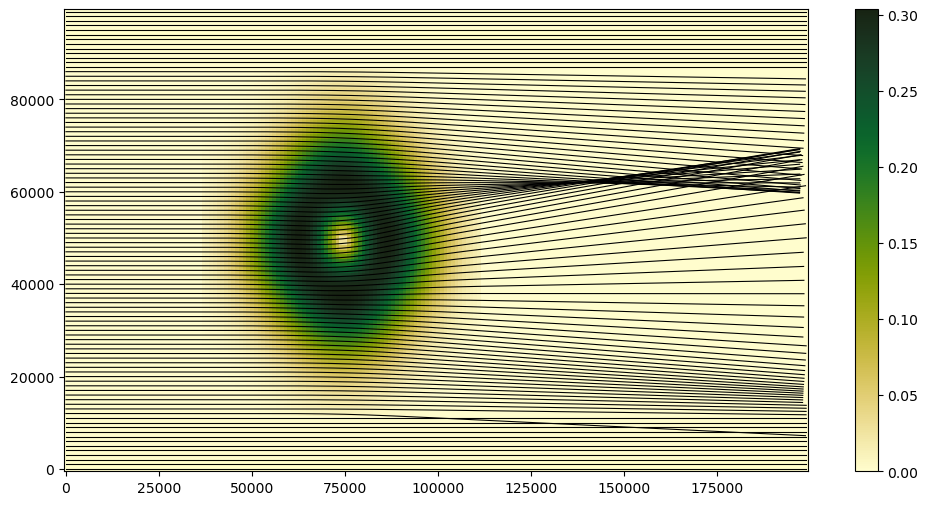

In [45]:
X = ds_eddy.x
Y = ds_eddy.y
U = (ds_eddy.u**2 + ds_eddy.v**2)**.5

plt.figure(figsize=(12, 6))

cf = plt.pcolormesh(X, Y, U, cmap=cmocean.cm.speed)

for i in range(bundle_eddy.ray.size)[::1]:
    ray = bundle_eddy.isel(ray=i)
    plt.plot(ray.x, ray.y, 'k', lw=.78)

plt.colorbar(cf)

## Gaussian Island

In [46]:
static_cur_path = './data/currents/homogeneous.nc'
island_path     = './data/bathymetry/island.nc'

In [47]:
bundle_island = mantaray.ray_tracing(x0, y0, K_x0, K_y0, 
                                        duration, timestep, 
                                        island_path, static_cur_path)

In [48]:
ds_island = xr.open_dataset(island_path)

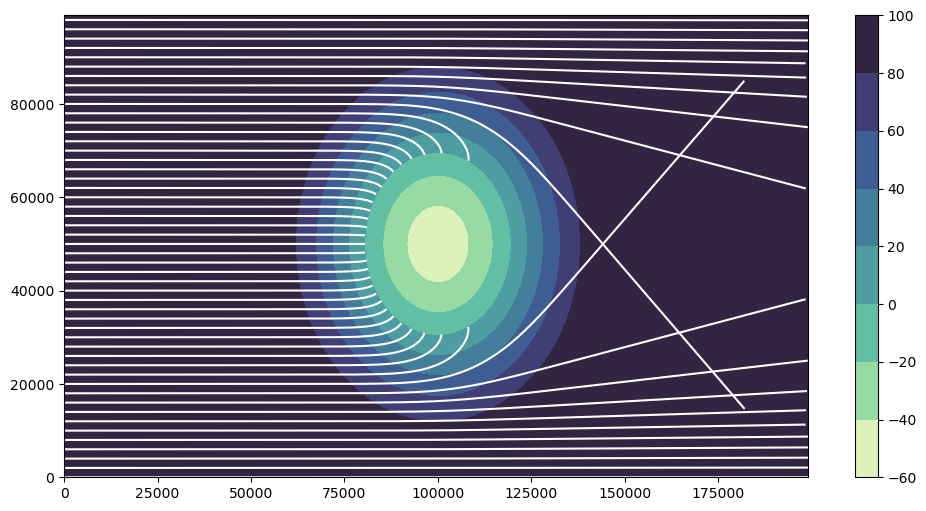

In [51]:
X = ds_eddy.x
Y = ds_eddy.y
H = ds_island.depth

plt.figure(figsize=(12, 6))

cf = plt.contourf(X, Y, H, cmap=cmocean.cm.deep)

for i in range(bundle_island.ray.size)[::2]:
    ray = bundle_island.isel(ray=i)
    plt.plot(ray.x, ray.y, color='white')

plt.colorbar(cf)

# Interactive Animations

Any ray tracing example can be animated.

In [54]:
X = ds_jet.x
Y = ds_jet.y
U = (ds_jet.u**2 + ds_jet.v**2)**.5

In [57]:
jet_anim = animate_rays(X,Y,U,
                        bundle_jet,
                        style='currents', ray_sample=2)

/var/folders/30/l7lkprrx2c32s7j5y82c67300000gq/T/ipykernel_33934/1267866538.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ray, = ax.plot([], [], 'k', lw=0.78, color='black')


WARNING: this cell make take some time to compute.

In [58]:
HTML(jet_anim.to_jshtml())

/Users/colin_beyers@mines.edu/ray_tracing/.pixi/envs/test/lib/python3.12/site-packages/matplotlib/animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [ ]:
# anim.save('/Users/colin_beyers@mines.edu/Desktop/waves.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


# BONUS: Other Ray Tracing Examples

## Concertina Effect

In [52]:
concertina_path = './data/currents/concertina.nc'

In [53]:
bando_cncrt = mantaray.ray_tracing(x0, y0, K_x0, K_y0, 
                                    duration, timestep, 
                                    const_bathy_path, concertina_path)

NameError: name 'colors' is not defined

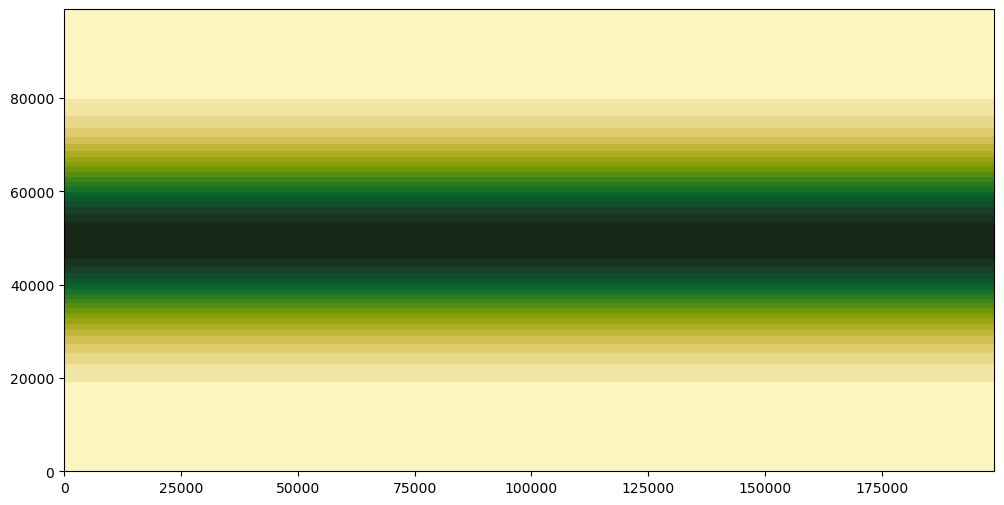

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcollections
from matplotlib.colors import ListedColormap, BoundaryNorm
import cmocean

fig, ax = plt.subplots(figsize=(12, 6))

# Plot background contour
cf = ax.contourf(X, Y, U, cmap=cmocean.cm.speed, alpha=1, levels=20)

# Define a stepwise colormap from grey to white with 10 steps
colors_list = ["#808080", "#909090", "#A0A0A0", "#B0B0B0", "#C0C0C0", 
               "#D0D0D0", "#E0E0E0", "#E8E8E8", "#F0F0F0", "#FFFFFF"]
cmap = ListedColormap(colors_list)
normie = BoundaryNorm(np.linspace(np.nanmin(colors), np.nanmax(colors), len(colors_list)+1), cmap.N)

segments = []
colors = []
midpoints_x = []
midpoints_y = []

for i in range(bando_cncrt.ray.size)[::2]:  # Skip every other ray for clarity
    ray = bando_cncrt.isel(ray=i)
    
    # Stack x, y coordinates as line segments
    points = np.column_stack([ray.x.values, ray.y.values])
    
    # Create segments from consecutive points
    for j in range(len(points) - 1):
        segment = points[j:j+2]
        segments.append(segment)
        
        # Assign color based on wavenumber at segment start
        colors.append(ray.kx.values[j])
        
        # Calculate midpoint
        mid_x = (segment[0, 0] + segment[1, 0]) / 2
        mid_y = (segment[0, 1] + segment[1, 1]) / 2
        midpoints_x.append(mid_x)
        midpoints_y.append(mid_y)

# Convert to NumPy arrays
colors = np.array(colors)

# Create a LineCollection from segments
lc = mcollections.LineCollection(segments, cmap=cmap, norm=normie, linewidth=2)
lc.set_array(colors)  # Assign color array

ax.add_collection(lc)  # Add colored lines to the plot
fig.colorbar(lc, ax=ax, label='kx Wavenumber')  # Add colorbar

plt.show()

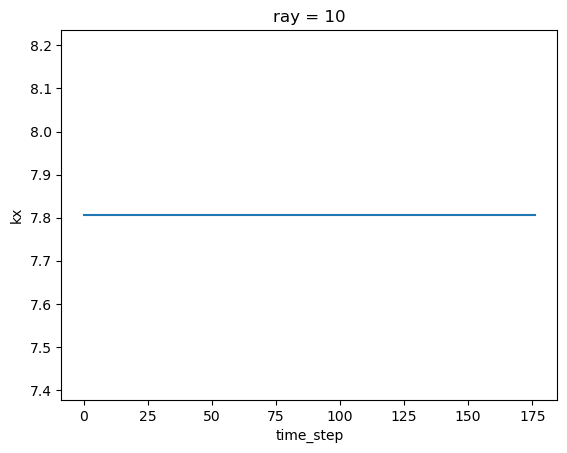

In [60]:
group_velocity(bando_cncrt.sel(ray=10)['kx']).plot()

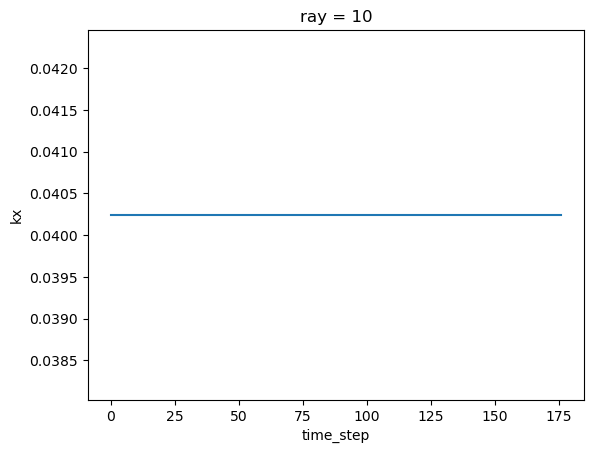

In [61]:
bando_cncrt.sel(ray=10)['kx'].plot()

## BONUS: A Gentle Beach

For this example, we will start the rays from a line on an angle.

In [62]:
theta0 = np.deg2rad(35)

# Calculate wavenumber components
k_x0 = k_0*np.cos(theta0)
k_y0 = k_0*np.sin(theta0)

In [63]:
n_rays = 50

# Initialize wavenumber for all rays
Kx0 = k_x0 * np.ones(n_rays)
Ky0 = k_y0 * np.ones(n_rays)

In [64]:
step_size = compute_cfl(x, y, k_0)
duration  = compute_duration(x, k_0)

In [65]:
# Parameters
x_start = 5000  # Start x coordinate (m)
y_start = 10    # Start y coordinate (m)
line_length = 5000  # Total length of the line (m)

# Calculate the step size in the x and y directions
dx = -line_length / n_rays * np.cos(np.pi/2 - theta0)
dy = line_length / n_rays * np.sin(np.pi/2 - np.pi/4)

# Generate the coordinates along the line
x0 = x_start + np.linspace(0, dx*(n_rays-1), n_rays)  # x coordinates
y0 = y_start + np.linspace(0, dy*(n_rays-1), n_rays)  # y coordinates

In [69]:
beach_path = './data/bathymetry/beach.nc'

In [78]:
bando_beach = mantaray.ray_tracing(x0, y0, Kx0, Ky0, 
                                duration, 50, 
                                beach_path, static_cur_path)

In [79]:
ds_beach = xr.open_dataset(beach_path)

/var/folders/30/l7lkprrx2c32s7j5y82c67300000gq/T/ipykernel_33934/1304307511.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(ray.x, ray.y, 'k', lw=.78, color='white')


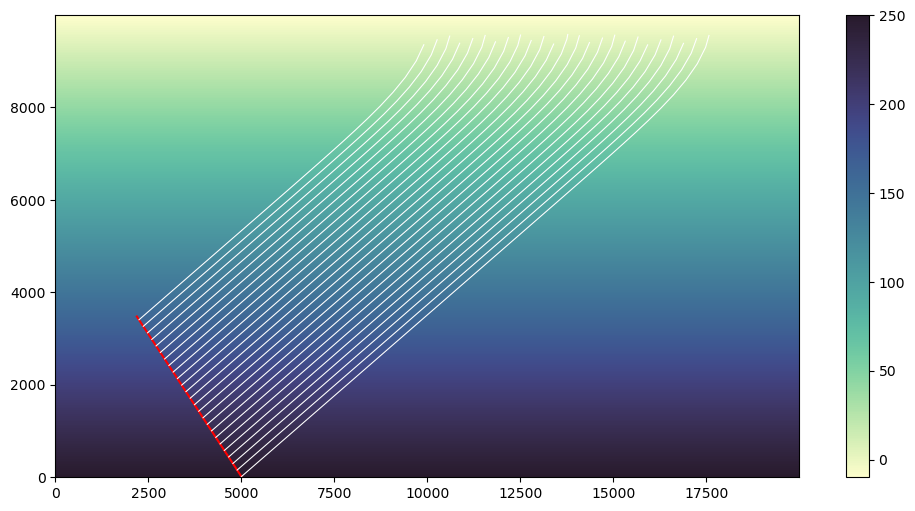

In [80]:
X = ds_beach.x
Y = ds_beach.y
H = ds_beach.depth

plt.figure(figsize=(12, 6))

# cf = plt.contourf(X, Y, H, cmap=cmocean.cm.deep, levels=20)
cf = plt.pcolormesh(X, Y, H, cmap=cmocean.cm.deep)
line = plt.plot(x0, y0, label="Line at points (x0, y0)", color='red')


for i in range(bando_beach.ray.size)[::2]:
    ray = bando_beach.isel(ray=i)
    plt.plot(ray.x, ray.y, 'k', lw=.78, color='white')

plt.colorbar(cf)